In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
dl = LFWDataLoader(batch_size=64)

train_ds, train_dl = dl.train_dataset, dl.train_dataloader
val_ds, val_dl = dl.val_dataset, dl.val_dataloader
test_ds, test_dl = dl.test_dataset, dl.test_dataloader

(10586, 3, 125, 94)
(1323, 3, 125, 94)
(1324, 3, 125, 94)


In [15]:
from model import Encoder, Decoder, AutoEncoder
from loss import LogCoshLoss

model = AutoEncoder()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, optim, device, train_dl, val_dl,kl_factor=1e-5,kl_rate=1e-4)
torch.cuda.empty_cache()
trainer.train_model(epochs=15)

5760327
EPOCH:  0
Iteration 0, loss = 1.2679
KL Factor: 0.000010
Avg Loss on Val: 0.23547517685663133



KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


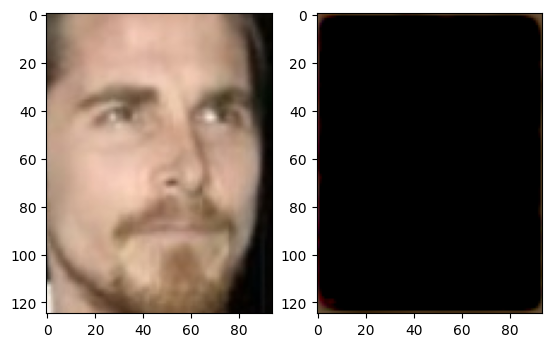

In [97]:
f = plt.figure()
tensor_image, = test_ds[200]
f.add_subplot(1,2,1)
plt.imshow(tensor_image.permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image.unsqueeze(0)
    scores,_ = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


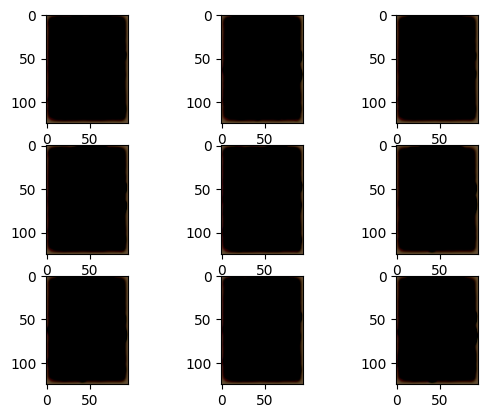

In [98]:
encoder = model.encoder
decoder = model.decoder
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(0,1,(9,64)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

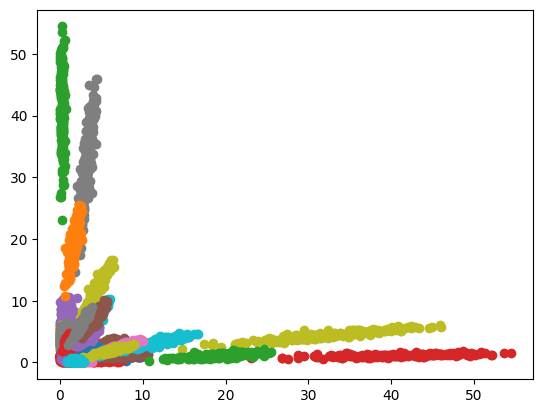

In [100]:
encoder = model.encoder
tensor_image, = test_ds[:200]
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu')
latent_mu = latent_mu.to('cpu')
for i in range(50):
    plt.scatter(np.abs(latent_var[:,i]),np.abs(latent_var[:,i+1]))
    # plt.scatter(latent_mu[:,i],latent_mu[:,i+1])

In [11]:
import gc 
model = 1
del model 
gc.collect()
plt.close()
with torch.no_grad():
    torch.cuda.empty_cache()